<a href="https://colab.research.google.com/github/harihardiyan/tdgl-gl-benchmark/blob/main/notebooks/Differentiable_Inverse_Design_(Optimize_B0_for_Target_Vortex_Count).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/harihardiyan/tdgl-gl-benchmark.git
%cd tdgl-gl-benchmark

!pip install -r requirements.txt --quiet

Cloning into 'tdgl-gl-benchmark'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (66/66), done.
Receiving objects: 100% (72/72), 779.91 KiB | 8.21 MiB/s, done.
remote: Total 72 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (27/27), done.
/content/tdgl-gl-benchmark


In [2]:

from tdgl_core import (
    init_params_basic,
    init_state_random,
    tdgl_step,
    total_energy,
    to_complex,
)

from tdgl_core.observables import (
    detect_vortices_phase_winding,
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:

# Differentiable Inverse Design (Optimize B0 for Target Vortex Count)

We use JAX gradients to adjust B0 such that
the resulting TDGL state has a desired number of vortices.

In [3]:

def run_tdgl_for_B0(B0,
                    nx=64, ny=64,
                    steps=1200,
                    dt=0.01,
                    noise=0.3,
                    seed=0):
    params = init_params_basic(nx=nx, ny=ny, B0=B0)
    key = jax.random.PRNGKey(seed)
    state = init_state_random(params, noise=noise, key=key)

    def body(s, _):
        return tdgl_step(s, params, dt), None

    state, _ = jax.lax.scan(body, state, jnp.arange(steps))

    psi = to_complex(state.psi)
    vort_mask = detect_vortices_phase_winding(psi)
    vort_count = jnp.sum(vort_mask == 1)

    return vort_count.astype(jnp.float32)

In [4]:

target_vort = 4.0   # desired vortex count

def loss_fn(B0):
    vort = run_tdgl_for_B0(B0)
    return (vort - target_vort)**2

In [5]:

loss_grad = jax.jit(jax.grad(loss_fn))
loss_jit = jax.jit(loss_fn)

In [6]:

B0 = 0.10          # initial guess
lr = 0.05          # learning rate
n_iter = 12

history_B0 = []
history_loss = []
history_vort = []

for k in range(n_iter):
    L = loss_jit(B0)
    g = loss_grad(B0)
    vort = run_tdgl_for_B0(B0)

    history_B0.append(float(B0))
    history_loss.append(float(L))
    history_vort.append(float(vort))

    print(f"iter {k:02d} | B0={B0:.4f} | vort={vort:.2f} | loss={L:.4f} | grad={g:.4f}")

    B0 = B0 - lr * g

iter 00 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 01 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 02 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 03 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 04 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 05 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 06 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 07 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 08 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 09 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 10 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000
iter 11 | B0=0.1000 | vort=278.00 | loss=75076.0000 | grad=0.0000


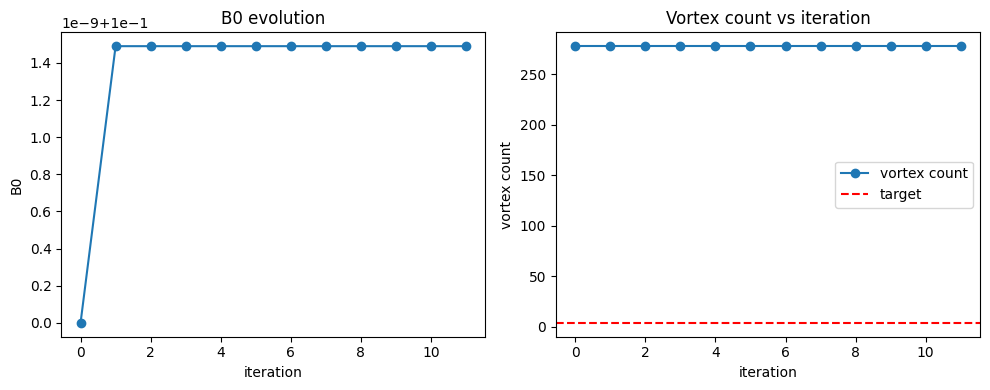

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(history_B0, "o-")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("B0")
ax[0].set_title("B0 evolution")

ax[1].plot(history_vort, "o-", label="vortex count")
ax[1].axhline(target_vort, color="red", linestyle="--", label="target")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("vortex count")
ax[1].set_title("Vortex count vs iteration")
ax[1].legend()

plt.tight_layout()
plt.show()

In [8]:

B0_opt = B0
print("Optimized B0:", float(B0_opt))

# Run once more and visualize
vort = run_tdgl_for_B0(B0_opt)
print("Final vortex count:", float(vort))

Optimized B0: 0.10000000149011612
Final vortex count: 278.0


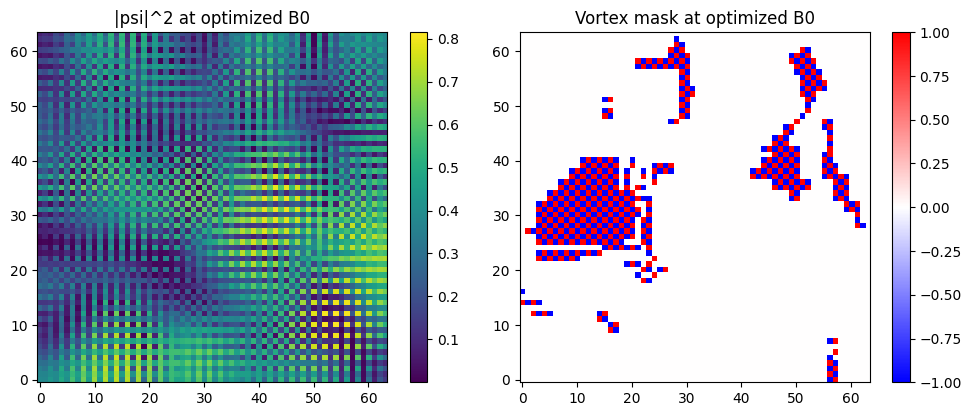

In [9]:

params = init_params_basic(nx=64, ny=64, B0=B0_opt)
state = init_state_random(params, noise=0.3)

steps = 1200
dt = 0.01
for _ in range(steps):
    state = tdgl_step(state, params, dt)

psi = to_complex(state.psi)
dens = jnp.abs(psi)**2
vort_mask = detect_vortices_phase_winding(psi)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(dens, origin="lower", cmap="viridis")
plt.title("|psi|^2 at optimized B0")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(vort_mask, origin="lower", cmap="bwr")
plt.title("Vortex mask at optimized B0")
plt.colorbar()

plt.tight_layout()
plt.show()